# 1. Business Understanding

### Business Problem

- Build a solution in 3 days in python that predicts **if patients will suffer from stroke or not** 
using a 70:30 split between the train and test datasets. This will be used by hospital to send patients to proper treatment.

- Try out a few different ML algorithms, evaluate them, compare them and **choose the best ML model** by providing a proper justification.

- Create a presentation in powerpoint where you will walk the main stakeholder, Director of VU University Medical Center
through the **solution**, and provide a **recommendation** as well as the **next steps** that you would take with more time.

### Analyze scenarios

Problem understanding: 
- The problem is a supervised binary classification (if patient will suffer a stroke or not). 
- We are concerned with accuracy and precision to identify the patients at risk. 
- False positive is ok (we err on the safe side). 
- False negative should be minimized ideally. 

Resources: 
We are given a data set with attributes and labels. We need to check if: 
- the data is clean, filter out NaN (...). 
- The data includes categorical and numeric variables. We will need to do at least some basic feature engineering to convert the data into numeric to use in different algorithms. 

### Data mining problem

- Need a pipeline for supervised binary classification
- Need to address issue of imbalance data sets (fewer strokes than non strokes)
- Need to clean data and create feature engineering
- Need to test different algorithms 
    - Logistic regression (simple but require data cleaning) 
    - Decision tree
    - Naive Bayes (suppose each feature is independant - check collinearity)
    - SVM
    - Random forest
    - Boosting
- Avoid those methods due risks of overfitting: 
    - KNN, Deep Learning (not enough data)
- Looking for prediction in 90% accuracy/ precision range.

- Note: Lime / Shap explainability. GOOD POINT at the end or to go Further (suggestion)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from scipy import stats
import os
from functools import partial

%matplotlib inline

# 2. Understand datasets and features

### Load datasets

In [2]:
stroke_pred=pd.read_csv('Stroke_Prediction.csv', sep=',')

In [3]:
print(stroke_pred.shape)
print(stroke_pred.info())

(43400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
ID                43400 non-null int64
Gender            43400 non-null object
Age_In_Days       43400 non-null float64
Hypertension      43400 non-null int64
Heart_Disease     43400 non-null int64
Ever_Married      43400 non-null object
Type_Of_Work      43400 non-null object
Residence         43400 non-null object
Avg_Glucose       43400 non-null float64
BMI               41938 non-null float64
Smoking_Status    30108 non-null object
Stroke            43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB
None


We see that we have a lot of NaN Smoking_Status and to some degree in BMI. We will investigate this later.

In [4]:
stroke_pred.head(2)

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [5]:
stroke_pred.shape

(43400, 12)

### Understand stroke 

** What is a stroke**
    
A stroke is a “brain attack”. It can happen to anyone at any time. It occurs when blood flow 
to an area of brain is cut off. When this happens, brain cells are deprived of oxygen and 
begin to die. When brain cells die during a stroke, abilities controlled by that area 
of the brain such as memory and muscle control are lost.
    
**3 types of stroke**

- Ischemic Stroke: a blood vessel carrying blood to the brain is blocked by a blood clot (ischemic)
- Transient ischemic Stroke (TIS): when blood flow to part of the brain stops for a short period of time
- Hemorrhagic Stroke : the least frequent but most lethal

**Strokes are a very important problem**
- 800,000 strokes per year in the US
- Fitfh leading cause of death in the US
- Leading cause of adult disability in the US
- 80% are preventable

**Lifestyle factors** : factors for stroke people choose to engage in
- Eating habits
- Physical activity
- Smoking and drinking 

**Medical risk factors** : factors for stroke that can be controlled
- High blood pressure
- Atrial fibrillation (AFib)
- High cholesterol
- Diabetes (see note below)
- Circulation problems 

**Non controlable factors** : factors we cannot control
- Age
- Gender
- Ethnicity    

Source: 
https://www.stroke.org/understand-stroke/what-is-stroke/

Note: Diabetes
Epidemiologic studies have shown that diabetes is a well-established independent but modifiable risk factor for stroke, both ischemic and hemorrhagic stroke. Diabete is essentially Type 2 (Insulin independant) due to Obesity. With uncontrolled level of Glucosis it can lead to risk of death in case of stroke. 

Source: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5298897/

### Understand stroke attributes in the data file

**ID**: Probably irrelevant unless to avoid duplicates

**Gender**: Relevant: different risks characteristics for men and women

**Age in days**: Relevant: different risks by age

**Hypertension**: Relevant:
- Hypertension is another name for high blood pressure. 
- Can lead to severe complications and increases the risk of heart disease, stroke, and death.
- Could be caused by diet issue (increase of salt intake from processed food according to WHO)
- Normal blood pressure is 120 over 80 mm of mercury (mmHg), but hypertension is higher than 130 over 80 mmHg.

Source: 
https://www.medicalnewstoday.com/articles/150109.php
    
**Heart_Disease**: relevant: could cause increase risks. Six causes.
- Heart disease symptoms in your blood vessels (atherosclerotic disease)
- Heart disease symptoms caused by abnormal heartbeats (heart arrhythmias)
- Heart disease symptoms caused by heart defects
- Heart disease symptoms caused by weak heart muscle (dilated cardiomyopathy)
- Heart disease symptoms caused by heart infections
- Heart disease symptoms caused by valvular heart disease

Source
https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118
    
**Ever_married** Lifestyle factor. Is this relevant?
-We will need to test. 

**Type_Of_Work** Lifestyle factor. Is this relevant?
-We will need to test. 

**Residence** Lifestyle factor. Is this relevant?
-We will need to test. 

**Avg_Glucose**: Could be relevant. Could create inflammation blocking arteries.
- For people who don't have diabetes, the normal range for an A1c is between 4 percent and 6 percent. 
This number is the percent of glucose attached to their red blood cells. 
This means their average blood sugar is between 70 and 126 mg/dl.
- Most people with diabetes aim for an A1c score of 7 percent or lower. This means an eAG of 154 mg/dl or less. 
- Pregnant women with diabetes should aim for
an A1c between 4 percent and 7 percent.

Source: 
https://wa.kaiserpermanente.org/healthAndWellness/index.jhtml?item=%2Fcommon%2FhealthAndWellness%2Fconditions%2Fdiabetes%2Fa1c.html
    
**BMI** or Body Mass Index. Relevant. Could be relevant. To test.
- An index for assessing overweight and underweight, obtained by dividing body weight in kg by height in m^2: 
- A measure of 25 or more is considered overweight.   


**Smoking_Status** : relevant. Lifestyle factor.

Source:
https://www.dictionary.com/browse/body-mass-index

### Exploratory Data Analysis and Visualizations

#### Basic statistics

In [6]:
basic_stat = round(stroke_pred.describe(),2)
basic_stat

,ID,Age_In_Days,Hypertension,Heart_Disease,Avg_Glucose,BMI,Stroke
count,43400.00,43400.00,43400.00,43400.00,43400.00,41938.00,43400.00
mean,36875.48,15446.23,0.09,0.05,104.48,28.61,0.02
std,21072.89,8334.88,0.29,0.21,43.11,7.77,0.13
min,176.00,-16381.00,0.00,0.00,55.00,10.10,0.00
25%,18594.25,8789.00,0.00,0.00,77.54,23.20,0.00
50%,36908.00,16074.00,0.00,0.00,91.58,27.70,0.00
75%,55054.25,21923.25,0.00,0.00,112.07,32.90,0.00
max,73899.00,264301.00,1.00,1.00,291.05,97.60,1.00


Lots of insights already from those basic statistics.
- We see that some ages are negative, or above 100 years. Will need to be cleaned.
- BMI average is quite high for the NL... Looks more like a US average...
- Only 2% stroke.
- Strong standard deviation for Avg_Glucose...
- Need to see if ID is unique or not (same patient seen over time...)

#### Initial data cleaning

- To simplify the Jupiter Notebook visualization, I deal now with outliers (Age) , ID, missing info (NaN), and whether Children data is relevant for our model. In the Crips methodology, this is normally dealt with after Data exploration in the Data quality stage.

1. Age

In [7]:
# Remove outliers:
# Must be superior to zero
stroke_pred = stroke_pred[stroke_pred['Age_In_Days'] >= 0]

# Must be inferior to 100 years (good enough life)
stroke_pred = stroke_pred[stroke_pred['Age_In_Days'] <= 36500]

# Convert days into years 
stroke_pred['Age_In_Days'] = stroke_pred['Age_In_Days'].div(365)

# Rename column Age_In_Days in Age
stroke_pred = stroke_pred.rename(columns={'Age_In_Days': 'Age'})

stroke_pred.shape
# Print # patients removed. 

(43394, 12)

2. IDs

In [8]:
# Unique IDs
Numb_ID_unique=stroke_pred['ID'].nunique( )
print("There are ",Numb_ID_unique , "uniques IDs out of", stroke_pred.shape[0])

There are  32713 uniques IDs out of 43394


In [9]:
# non unique IDs.
duplicated_ID=stroke_pred[stroke_pred.duplicated(subset=['ID'],keep=False)]
duplicated_ID_sort=duplicated_ID.sort_values('ID')
print("There are ",duplicated_ID_sort.shape[0], "duplicated IDs")
duplicated_ID_sort.head(10)


There are  19485 duplicated IDs


,ID,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
35529,336,Male,37.024658,0,0,Yes,Self-employed,Rural,70.80,29.4,NaN,0
21299,336,Female,10.134247,0,0,No,children,Rural,87.70,21.1,NaN,0
17144,350,Female,67.008219,0,0,Yes,Private,Rural,94.58,35.2,formerly smoked,0
29677,350,Female,58.057534,0,0,Yes,Private,Rural,82.76,30.7,never smoked,0
39783,384,Female,57.112329,1,0,Yes,Private,Rural,102.64,34.1,never smoked,0
20900,384,Female,39.106849,0,0,Yes,Private,Urban,113.57,30.5,never smoked,0
7184,384,Female,52.049315,0,0,Yes,Self-employed,Urban,199.55,NaN,formerly smoked,0
7748,386,Male,15.060274,0,0,No,Private,Urban,86.74,26.0,never smoked,0
40882,386,Female,54.002740,0,0,Yes,Govt_job,Rural,106.23,24.4,never smoked,0
38416,407,Male,51.024658,0,0,Yes,Private,Rural,106.73,NaN,never smoked,0


**By looking at those IDs, we see some data issues.**
- Men/women mix for same IDs. 
- For same Gender, the data does not match (ex: incoherent answer for formerly smoked / never smoked)
- For simplicity sake, we will ignore the IDs and assume the underlying data is correct
- This needs to be discussed with the stakeholders going forward, to see if we can track patient data over time

In [10]:
# Remove the ID
stroke_pred = stroke_pred.drop(['ID'], axis=1)
stroke_pred.drop_duplicates
stroke_pred.shape

(43394, 11)

3. Analyze the missing values (NaN)

In [13]:
stroke_pred.isnull().sum()   

Gender                0
Age                   0
Hypertension          0
Heart_Disease         0
Ever_Married          0
Type_Of_Work          0
Residence             0
Avg_Glucose           0
BMI                1461
Smoking_Status    13289
Stroke                0
dtype: int64

Text(0.5,1,'Percent missing data by feature or label')

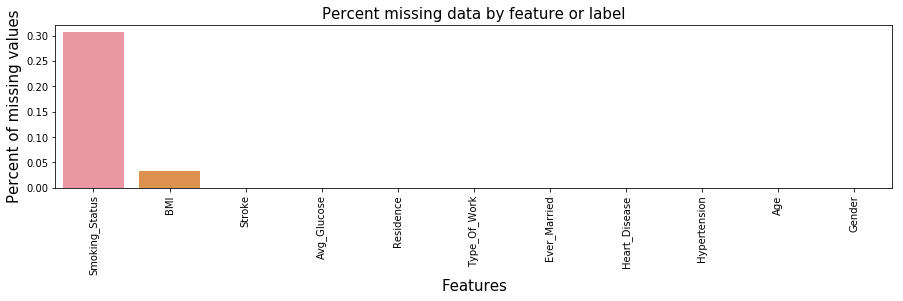

In [12]:
total = stroke_pred.isnull().sum().sort_values(ascending=False)
percent = (stroke_pred.isnull().sum()/stroke_pred.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 3))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature or label', fontsize=15)

- Since only 3% of BMI data are missing, we will replace them with the mean. 
- This will diminish the correlation with other variables but only marginally.

In [14]:
stroke_pred.BMI.fillna(stroke_pred.BMI.mean(),inplace=True)

- Since more than 30% of Smoking data are missing, we will replace them with a new category:unknown, 
    - except in the case of kids below the age of 10, we will put 'never smoked' (which is the most likely)
- It is like adding a new isnull feature. Downside: we add a new feature, but it is ok. We have lots of data. 

In [15]:
stroke_pred.Smoking_Status.fillna('unknown',inplace=True)

stroke_pred.loc[(stroke_pred['Age']<=10),'Smoking_Status']='never smoked'

4. Check if children data is relevant: test # Children vs # Adults cases of stroke

- We create a function to compare for each the number of stroke and stroke % (we will use this thru this notebook), then to compare side by side with a histogram.

In [60]:
def nb_percent_stroke_equal(df,column,cat,depvar):
    test_c =df[df[column] == cat]  
    test_cs = test_c[test_c[depvar] == 1] 
    sp=round(test_cs.shape[0]/test_c.shape[0]*100,2)
    #print("Number of",cat,":", test_c.shape[0], " stroke number:",test_cs.shape[0],
    #  ",stroke percent :",sp)
   # df1=pd.DataFrame([test_c.shape[0],test_cs.shape[0],sp])
    a1=np.array([[test_c.shape[0],test_cs.shape[0],sp]])
    return a1;

def nb_percent_stroke_notequal(df,column,cat,depvar):
    test_c =df[df[column] != cat]  
    test_cs = test_c[test_c[depvar] == 1] 
    sp=round(test_cs.shape[0]/test_c.shape[0]*100,2)
    #print("Number of non",cat,":", test_c.shape[0], " stroke number:",test_cs.shape[0],
    # ",stroke percent :",sp)
    a2=np.array([[test_c.shape[0],test_cs.shape[0],sp]])
    return a2;

In [61]:
from functools import partial
def compare(f1,cat1,f2,cat2,f3=None,cat3=None,f4=None,cat4=None, f5=None, cat5=None):
    if f3 is None:
        a=np.concatenate((f1(),f2()), axis=0)
        df= pd.DataFrame(columns=['nb observation', 'nb strokes', 'stroke%'])
        df=pd.DataFrame(data=a,    # values
        index=[cat1,cat2],    # index
        columns=["Nb observations","Stroke nb","Stroke %"])  # columns
    elif f4 is None:
        f3()
        a=np.concatenate((f1(),f2(),f3()), axis=0)
        df= pd.DataFrame(columns=['nb observation', 'nb strokes', 'stroke%'])
        df=pd.DataFrame(data=a,    # values
        index=[cat1,cat2,cat3],    # index
        columns=["Nb observations","Stroke nb","Stroke %"])  # columns
    elif f5 is None:
        f4()
        a=np.concatenate((f1(),f2(),f3(), f4()), axis=0)
        df= pd.DataFrame(columns=['nb observation', 'nb strokes', 'stroke%'])
        df=pd.DataFrame(data=a,    # values
        index=[cat1,cat2,cat3, cat4],    # index
        columns=["Nb observations","Stroke nb","Stroke %"])  # columns
    
    else: 
        a=np.concatenate((f1(),f2(),f3(),f4(),f5()), axis=0)
        df= pd.DataFrame(columns=['nb observation', 'nb strokes', 'stroke%'])
        df=pd.DataFrame(data=a,    # values
        index=[cat1,cat2,cat3,cat4, cat5],    # index
        columns=["Nb observations","Stroke nb","Stroke %"])  # columns   
         
    df1=df.T
    return df1;   
    
    '''

    # Ploting: Did not have time to figure this out
    
    
    # 2 plots
    fig, ax = plt.subplots(1,2, figsize=(12,2))
    title_1 = cat1, "Nb observations, Stroke nb, Stroke %"
    ax[0].set_title(title_1)
    df1[cat1].hist(color=['g'], ax=ax[0])
    
    title_2 = cat2, "Nb observations, Stroke nb, Stroke %"
    ax[1].set_title(title_2)
    df1[cat2].hist(color=['b'], ax=ax[1])
    
    # 3 plots
    fig, ax = plt.subplots(1,3, figsize=(12,2))
    title_1 = "Nb observations", cat1, cat2
    ax[0].set_title(title_1)
    df["Nb observations"].hist(color=['g'], ax=ax[0])
    
    title_2 = "Strokes nb", cat1, cat2
    ax[1].set_title(title_2)
    df["Stroke nb"].hist(color=['b'], ax=ax[1])
    
    title_3 = "Strokes %", cat1, cat2
    ax[2].set_title(title_3)
    df["Stroke %"].hist(color=['y'], ax=ax[2])
    
    
   # df.hist(column='session_duration_seconds', by='user_type', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)
   
    fig, ax = plt.subplots(1,2, figsize=(12,1.5))
    # 1st cat
    title_1 = cat1 + ", Stroke nb, Stroke%"
    ax[0].set_title(title_1)
    df.hist(df[:1], ax=ax[0])
    #sns.distplot(df[:1].values, ax=ax[0])   
    

    # 2n  cat
    title_2 = cat2 + ", Stroke nb, Stroke%"
    ax[1].set_title(title_2)
    sns.distplot(df[1:].values, ax=ax[1])
    '''


In [62]:
compare(
 partial(nb_percent_stroke_equal, stroke_pred,'Type_Of_Work','children','Stroke'),'Children',
 partial(nb_percent_stroke_notequal, stroke_pred,'Type_Of_Work','children','Stroke'),'Adults')

,Children,Adults
Nb observations,6154.00,37229.0
Stroke nb,2.00,781.0
Stroke %,0.03,2.1


** Conclusion**: We keep the children data, but it is clear that stroke is more relevant for adults: Age will be a factor for Stroke

5. Check if 'Gender' = 'Other' is relevant

In [361]:
stroke_pred[stroke_pred['Gender']=='Other'].shape

(11, 11)

In [20]:
stroke_pred[stroke_pred['Gender']=='Other'].head(11)

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
2914,Other,26.071233,0,0,No,Private,Rural,143.33,22.400000,formerly smoked,0
10768,Other,46.082192,0,0,No,Private,Rural,83.28,28.605449,never smoked,0
15620,Other,27.090411,0,0,No,Private,Urban,62.45,28.605449,smokes,0
15838,Other,53.071233,0,0,Yes,Private,Rural,89.65,28.605449,unknown,0
19748,Other,39.002740,0,0,Yes,Govt_job,Urban,95.59,32.000000,formerly smoked,0
21041,Other,19.131507,0,0,No,Private,Rural,75.76,32.200000,formerly smoked,0
21192,Other,49.104110,0,0,Yes,Private,Urban,94.88,37.200000,never smoked,0
24252,Other,51.043836,0,0,Yes,Private,Rural,91.75,32.200000,formerly smoked,0
26199,Other,10.101370,0,0,No,children,Rural,72.05,21.200000,formerly smoked,0
26831,Other,53.115068,0,0,Yes,Govt_job,Urban,65.29,28.605449,unknown,0


We do not have enough data to predict anything with 'Gender' = 'Other' (all no Stroke). We remove those 11 cases from our dataset.

In [21]:
stroke_pred = stroke_pred[stroke_pred['Gender']!='Other']

#### Univariate Analysis

We first look at each variable taken individually

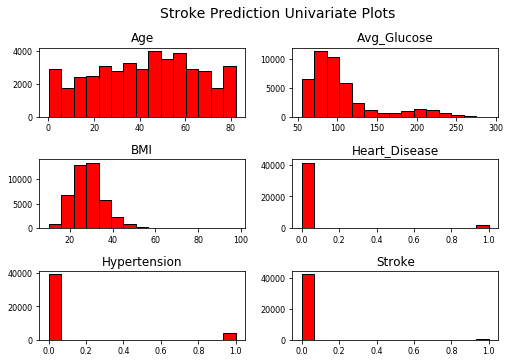

In [22]:
stroke_pred.hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
rt = plt.suptitle('Stroke Prediction Univariate Plots', x=0.65, y=1.25, fontsize=14)

**Comments**
- Heart_Disease, Hypertension seem to correlate with each other and with Stroke (we will verify that)
- Avg_Glucose is not a normal distribution and looks  a bit bimodal. The average is 104 with 43 standard deviation.
    - There seems to be a "normal group" around 70 (as predicted in the litterature) and a second group above 150.
    - Based on litterature review, it could be that the second group are people with Diabetes.
- BMI is slightly skewed to the right
- Age distribution: I was expecting a uniform distribution. 
    - It looks a bit normal around age 42 but spike for infants and old age (to be expected in an hospital)

**Inferential statistics**

1. Check if Heart_Disease is correlated to Hypertension 
They are two categorical variable. For that, we use the chi-square independence test:
    - H0: Null hypothesis. They are not related. 
    - Ha: Alternative hypothesis. They are related.

In [23]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(stroke_pred.Hypertension,stroke_pred.Heart_Disease)   
crosstab

Heart_Disease,0,1
Hypertension,,
0,37775,1547
1,3546,515


In [24]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1],"<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("Heart_Disease and Hypertension are related in our data")

Chi-square value: 620.2101644789959 p-value: 6.730497352256946e-137 <0.05, degree of freedom: 1
All expected frequencies [[37453.01989258  1868.98010742]
 [ 3867.98010742   193.01989258]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
Heart_Disease and Hypertension are related in our data


2. Check if Heart_Disease is correlated to Stroke
They are two categorical variable. We use the chi-square independence test:
    - H0: Null hypothesis. They are not related. 
    - Ha: Alternative hypothesis. They are related.

In [25]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(stroke_pred.Heart_Disease,stroke_pred.Stroke)   
crosstab

Stroke,0,1
Heart_Disease,,
0,40715,606
1,1885,177


In [34]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1], "<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("Heart_Disease and Stroke are related in our data")

Chi-square value: 244.28428808813473 p-value: 4.576918098081863e-55 <0.05, degree of freedom: 1
All expected frequencies [[38623.27655897   709.72344103]
 [ 3987.72344103    73.27655897]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
Heart_Disease and Stroke are related in our data


3. Check if Hypertension is correlated to Stroke
They are two categorical variable. For that, we use the chi-square independence test:
    - H0: Null hypothesis. They are not related. 
    - Ha: Alternative hypothesis. They are related.

In [26]:
# We create a crosstabulation as input for the chi-square test of independence
crosstab=pd.crosstab(stroke_pred.Hypertension,stroke_pred.Stroke)   
crosstab

Stroke,0,1
Hypertension,,
0,38739,583
1,3861,200


In [27]:
chi2result=stats.chi2_contingency(crosstab)
chi2result
print("Chi-square value:", chi2result[0],"p-value:", chi2result[1], "<0.05, degree of freedom:", chi2result[2])
print("All expected frequencies", chi2result[3],"are >5, chi2 test results are valid") 
print("We reject the null hypothesis as the p-value is less than 0.05")
print("Hypertension and Stroke are related in our data")

Chi-square value: 244.15800128931716 p-value: 4.876490208447404e-55 <0.05, degree of freedom: 1
All expected frequencies [[38612.29513865   709.70486135]
 [ 3987.70486135    73.29513865]] are >5, chi2 test results are valid
We reject the null hypothesis as the p-value is less than 0.05
Hypertension and Stroke are related in our data


** Conclusion**: Hypertension, Heart_Disease and Stroke are all correlated in our data. 

#### Multivariate Analysis

We will now look at the correlation between groups of variables (pairs, multiple variables)

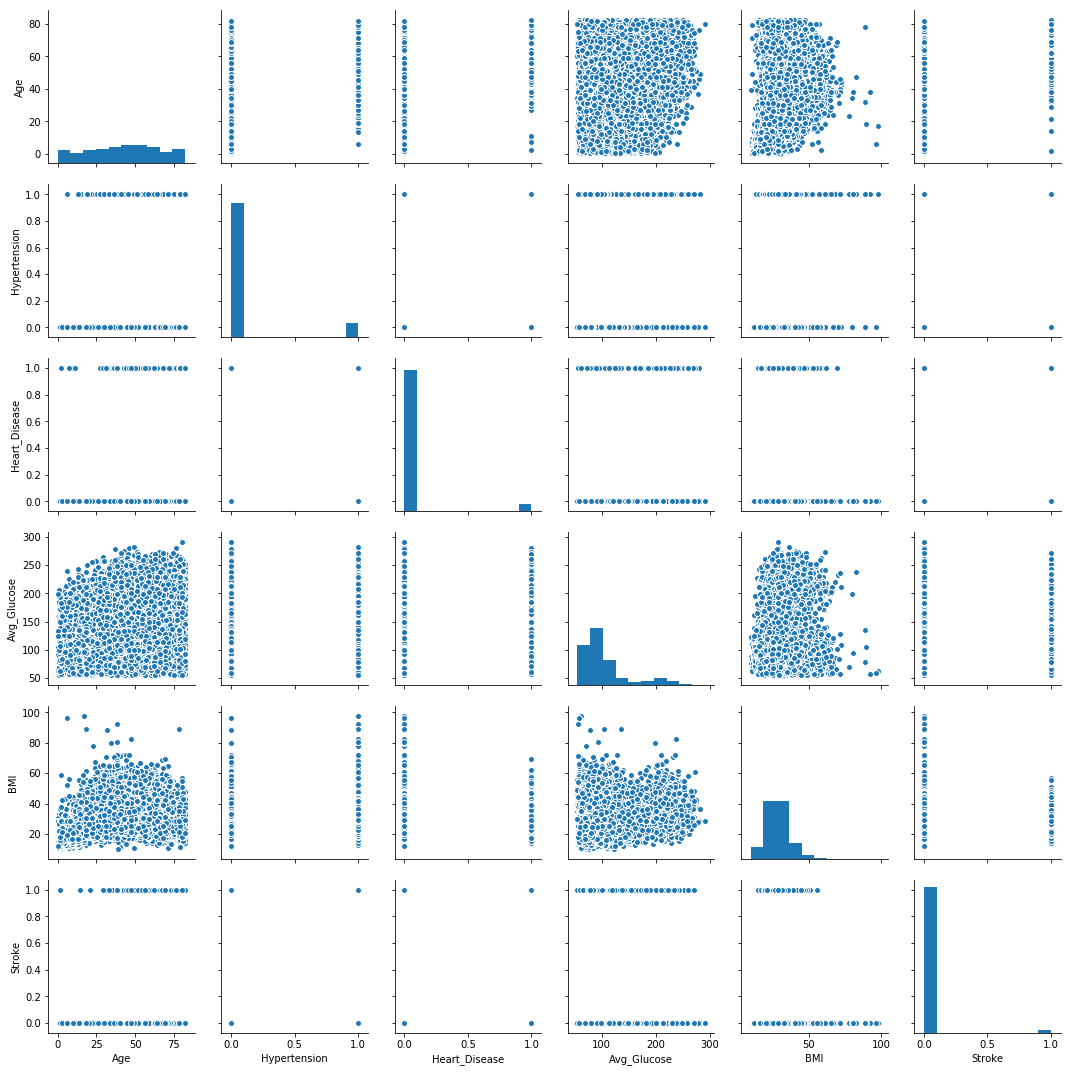

In [28]:
sns.pairplot(data=stroke_pred)


1. Influence of Gender, Age, BMI on Stroke

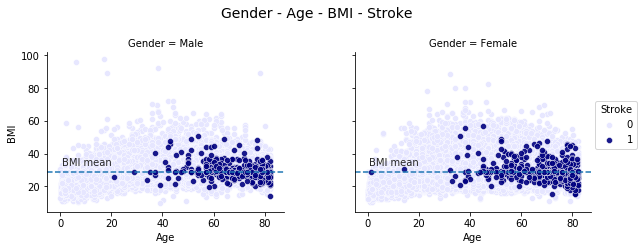

In [44]:
g = sns.FacetGrid(stroke_pred, col="Gender", hue='Stroke', 
                  col_order=['Male', 'Female'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 2))
g.map(plt.scatter, "Age", "BMI", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(28.61, ls='--')
    ax2.axhline(28.61, ls='--')
    ax1.text(0.5,33, "BMI mean")
    ax2.text(0.5,33, "BMI mean")

fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Gender - Age - BMI - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

- **Age** is a factor, there is a clear increase in stroke rate above 40 years. Almost no Stroke below 20 years.
    - An idea would be to bin Age: 0-20,20-40, 40-60, 60-80, 80-100
- **BMI** (obesity) should be a factor
    - There are more strokes one standard deviation around the BMI mean (+/- 7.65).
    - High BMI seem to contribute to slightly more strokes than low BMI. 
    - BMI mean is relevant, since we have few outliers.
- **Gender is a factor**: it is not clear on the chart, but clear if we run the numbers 

In [71]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Gender','Male','Stroke'),'`Male',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Gender','Female','Stroke'),'Female'
     )

,`Male,Female
Nb observations,9850.00,14360.00
Stroke nb,344.00,415.00
Stroke %,3.49,2.89


2. Influence of Gender, Age, Avg_Glucose on Stroke

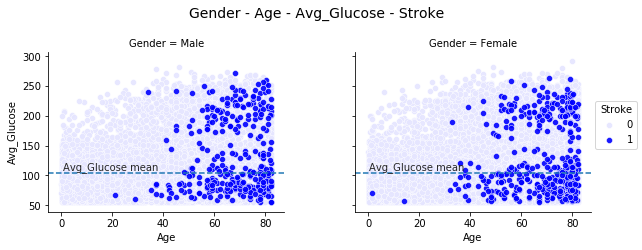

In [79]:
g = sns.FacetGrid(stroke_pred, col="Gender", hue='Stroke', 
                  col_order=['Male', 'Female'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('blue', 2))
g.map(plt.scatter, "Age", "Avg_Glucose", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(104.48, ls='--')
    ax2.axhline(104.48, ls='--')
    ax1.text(0.5,110, "Avg_Glucose mean")
    ax2.text(0.5,110, "Avg_Glucose mean")

fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Gender - Age - Avg_Glucose - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

- **Glucose is a factor** 
- Males/Female seem to have more stroke in very high glucose groups (above 170 mg/l) AND in low glucose groups (below 100 mg/l), but less so in beetween 100 and 170. 
- In one standard deviation above the mean, glucose seem to be less a factor (we see two separate groups)
- We will bin Avg_Glusose to get more insights



3. Influence of Marriage, Age, BMI on Stroke

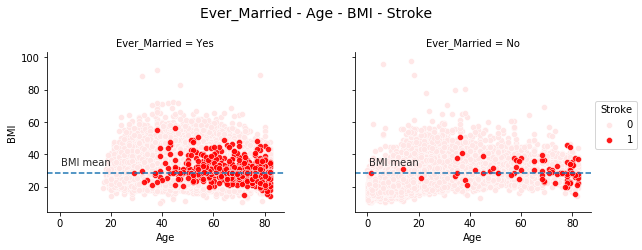

In [47]:
g = sns.FacetGrid(stroke_pred, col="Ever_Married", hue='Stroke', 
                  col_order=['Yes', 'No'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('red', 2))
g.map(plt.scatter, "Age", "BMI", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(28.61, ls='--')
    ax2.axhline(28.61, ls='--')
    ax1.text(0.5,33, "BMI mean")
    ax2.text(0.5,33, "BMI mean")

fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Ever_Married - Age - BMI - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

- **Marriage is a factor**. It appears like Ever_Married people = Yes are more affected by strokes after the age of 40 than non married people. **However**, since there are more married than non married people, this make sense. What matters is the stroke %.
- Based on the calculation below*, the risk of stroke is actually inferior for Ever_Married = Yes than non Married.
    - It would be ideal to assess people who are currently married vs non married but we don't have the data.
- BMI looks slightly higher for married than for non married people. 


In [63]:
stroke_pred40plus = stroke_pred[stroke_pred['Age'] >= 40]
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Ever_Married','Yes','Stroke' ),'Ever_Married people = Yes',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Ever_Married','No','Stroke'),'Ever_Married people = No')

,Ever_Married people = Yes,Ever_Married people = No
Nb observations,22219.0,1991.00
Stroke nb,689.0,70.00
Stroke %,3.1,3.52


4. Influence of Residence, Age, Avg_Glucose on Stroke

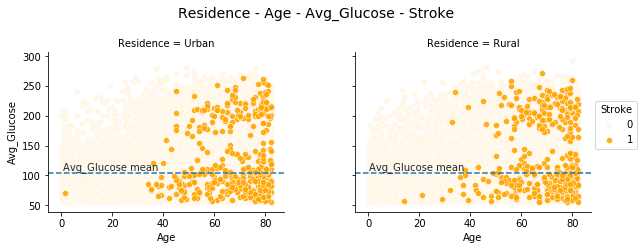

In [40]:
g = sns.FacetGrid(stroke_pred, col="Residence", hue='Stroke', 
                  col_order=['Urban', 'Rural'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('orange', 2))
g.map(plt.scatter, "Age", "Avg_Glucose", alpha=0.9, 
      edgecolor='white', linewidth=0.5)

with sns.axes_style("white"):
    ax1, ax2 = g.axes[0]
    ax1.axhline(104.48, ls='--')
    ax2.axhline(104.481, ls='--')
    ax1.text(0.5,110, "Avg_Glucose mean")
    ax2.text(0.5,110, "Avg_Glucose mean")
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Residence - Age - Avg_Glucose - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

In [70]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Residence','Urban','Stroke'),'`Residence = Urban',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Residence','Rural','Stroke'),'Residence = Rural'
     )

,`Residence = Urban,Residence = Rural
Nb observations,12177.00,12033.00
Stroke nb,388.00,371.00
Stroke %,3.19,3.08


- **Residence** is a small factor. With more time, we would do a significance test.

5. Influence of Work, Age, Avg_Glucose on Stroke

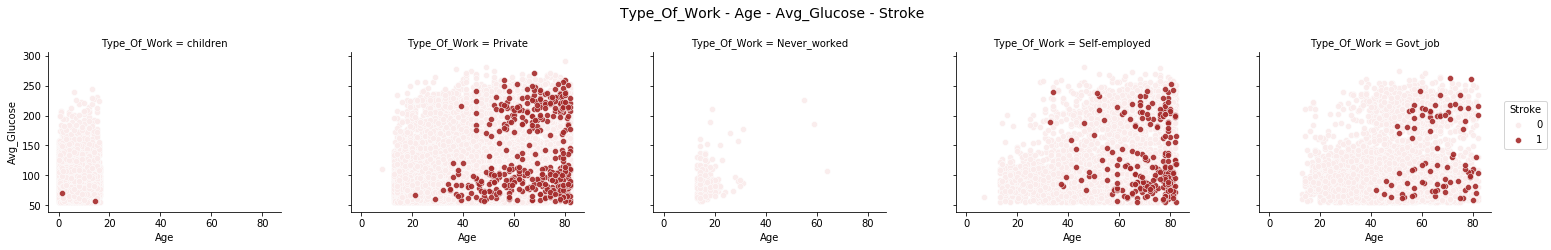

In [34]:
g = sns.FacetGrid(stroke_pred, col="Type_Of_Work", hue='Stroke', 
                  col_order=['children', 'Private', 'Never_worked', 'Self-employed', 'Govt_job'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "Age", "Avg_Glucose", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Type_Of_Work - Age - Avg_Glucose - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

- **Work** is a factor (more stroke in Private and Self-employed vs Govt_job). 
- However, we need to check the % since the class could be imbalanced.
- Based on the calculation below, Self-employed are more prone to stroke than Private and Govt_job

In [64]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Type_Of_Work','Private','Stroke'),'`Type_of_Work = Private',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Type_Of_Work','Self-employed','Stroke'),'Type_of_Work = Self-employed',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Type_Of_Work','Govt_job','Stroke'),'Type_of_Work = Govt_job'
     )

,`Type_of_Work = Private,Type_of_Work = Self-employed,Type_of_Work = Govt_job
Nb observations,14427.00,5818.00,3962.00
Stroke nb,424.00,246.00,89.00
Stroke %,2.94,4.23,2.25


6. Influence of Smoking, Age, BMI on Stroke

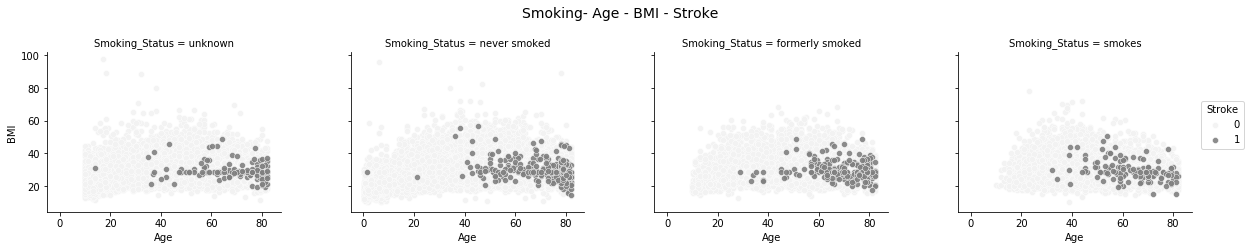

In [35]:
g = sns.FacetGrid(stroke_pred, col="Smoking_Status", hue='Stroke', 
                  col_order=['unknown','never smoked', 'formerly smoked', 'smokes'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('grey', 2))
g.map(plt.scatter, "Age", "BMI", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Smoking- Age - BMI - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

- **Smoking** seems to have an influence on stroke if we compare(current+former) smokers versus the group which never smoked.
- We need to be careful to interpret more stroke in the never smoked group (there could be simply more people) 
- Current smokers have a slightly lesser BMI than older smoers or people who never smoked. 
- The risk of stroke is highest with former smokers based on calculation below for Age >= 40.

In [65]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Smoking_Status','unknown','Stroke'),'`Smoking_Status = unknown',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Smoking_Status','never smoked','Stroke'),'Smoking_Status = never smoked',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Smoking_Status','formerly smoked','Stroke'),'Smoking_Status = formerly smoked',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Smoking_Status','smokes','Stroke'),'Smoking_Status = smokes'     
    )

,`Smoking_Status = unknown,Smoking_Status = never smoked,Smoking_Status = formerly smoked,Smoking_Status = smokes
Nb observations,4621.00,9610.00,5784.0,4195.00
Stroke nb,138.00,280.00,214.0,127.00
Stroke %,2.99,2.91,3.7,3.03


### Data Quality Analysis ###

For convenience purpose, we have put it before the data visualization.

1. Age and NaN.
We have already corrected the Age outliers, the missing NaN for BMI and Smoking_Status.

2. IDs
Something is wrong with the IDs (confere data cleaning).
Given the time available for the analysis, it is assumed that the data is of good quality and that the ID are irrelevant, that is: the observations (rows) are independant from each others. This is a key assumption. 
In a real project, we would check with the hospital why the IDs are not correct. 

3. Normalization and imbalance in datasets
Will need to be addressed in the Data Preparation Phase. 

### Correlation Matrix

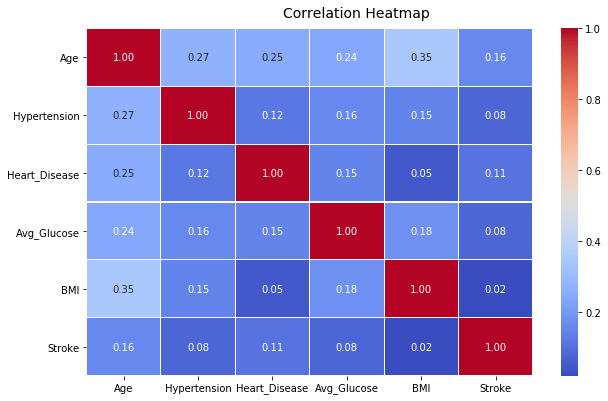

In [37]:
f, ax = plt.subplots(figsize = (10,6))
corr= stroke_pred.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t=f.suptitle("Correlation Heatmap",fontsize=14)

- Typically, a correlation Heatmap is only done on numeric variable. 
- By default, SNS correlation Heatmap also includes binary variables.
- What we see here is that no attributes explains -alone- the dependant variable,
- age 0.16 being the strongest predictor before heart disease 0.11 and Avg_Glucose 0.08. 
- BMI seems to be a low predictor.
- No variable seems to be fully correlated with each other (which is good for our modelling): this means there is low colinearity between the predictors variables

**Binning of BMI, Glucose data and Age**

In [49]:
# Binning for BMI data
bin_ranges_BMI = [0, 18.5, 24.9, 29.9, 49.9, 100]
bin_names_BMI = ['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Extr. Obese']

stroke_pred['BMI_range'] = pd.cut(np.array(
                           stroke_pred['BMI']), 
                           bins=bin_ranges_BMI)
                    
stroke_pred['BMI_cat'] = pd.cut(np.array(
                         stroke_pred['BMI']),
                         bins=bin_ranges_BMI,            
                         labels=bin_names_BMI)
#From litterature
#Underweight: BMI is less than 18.5
#Normal weight: BMI is 18.5 to 24.9
#Overweight: BMI is 25 to 29.9
#Obese: BMI is 30 to 49.9
#Extr. Obese: more than 50 (added)
#Source: https://www.cancer.org/cancer/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html

In [ ]:
# Influence of BMI categories, Age, Glucose on Stroke 

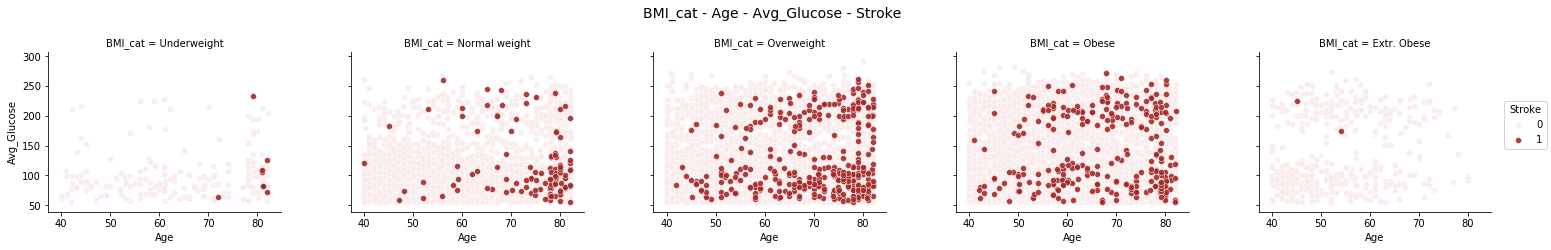

In [67]:
g = sns.FacetGrid(stroke_pred40plus, col="BMI_cat", hue='Stroke', 
                  col_order=['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Extr. Obese'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "Age", "Avg_Glucose", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('BMI_cat - Age - Avg_Glucose - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

In [66]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'BMI_cat','Underweight','Stroke'),'Underweight',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'BMI_cat','Normal weight','Stroke'),'Normal weight',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'BMI_cat','Overweight','Stroke'),'Overweight',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'BMI_cat','Obese','Stroke'),'Obese', 
    partial(nb_percent_stroke_equal, stroke_pred40plus,'BMI_cat','Extr. Obese','Stroke'),'Extr. Obese'     
    )

,Underweight,Normal weight,Overweight,Obese,Extr. Obese
Nb observations,203.00,4236.00,8566.0,10824.00,381.00
Stroke nb,8.00,116.00,360.0,273.00,2.00
Stroke %,3.94,2.74,4.2,2.52,0.52


In [51]:
# Binning for Avg_Glucose data
bin_ranges_Avg_Glucose = [0, 60, 140, 220, 300]
bin_names_Avg_Glucose = ['Low AG', 'Normal AG', 'High AG','Very high AG']

stroke_pred['Avg_Glucose_range'] = pd.cut(np.array(
                           stroke_pred['Avg_Glucose']), 
                           bins=bin_ranges_Avg_Glucose)
                    
stroke_pred['Avg_Glucose_cat'] = pd.cut(np.array(
                         stroke_pred['Avg_Glucose']),
                         bins=bin_ranges_Avg_Glucose,            
                         labels=bin_names_Avg_Glucose)
#From litterature
#Low: AG is less than 60
#Normal : AG is 60 to 140 (Diabete people slightly higher)
#High: AG is 140 to 220
#Extremely High: AG is 220 to 300 (category added)
#Source:  https://wa.kaiserpermanente.org/healthAndWellness/index.jhtml?item=%2Fcommon%2FhealthAndWellness%2Fconditions%2Fdiabetes%2Fa1c.html

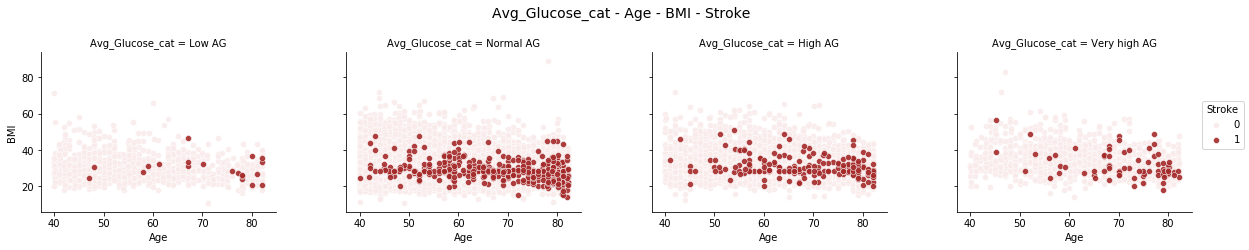

In [68]:
g = sns.FacetGrid(stroke_pred40plus, col="Avg_Glucose_cat", hue='Stroke', 
                  col_order=['Low AG', 'Normal AG', 'High AG','Very high AG'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "Age", "BMI", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Avg_Glucose_cat - Age - BMI - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

In [69]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Avg_Glucose_cat','Low AG','Stroke'),'Low AG',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Avg_Glucose_cat','Normal AG','Stroke'),'Normal AG',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Avg_Glucose_cat','High AG','Stroke'),'High AG',
    partial(nb_percent_stroke_equal, stroke_pred40plus,'Avg_Glucose_cat','Very high AG','Stroke'),'Very High AG'   
    )

,Low AG,Normal AG,High AG,Very High AG
Nb observations,901.00,18257.00,3703.00,1349.00
Stroke nb,20.00,469.00,195.00,75.00
Stroke %,2.22,2.57,5.27,5.56


In [74]:
# Binning for Age data
bin_ranges_Age = [0, 20, 40, 60, 80, 100]
bin_names_Age = ['Age<20', '20-40', '40-60', '60-80', '80-100']

stroke_pred['Age_range'] = pd.cut(np.array(
                           stroke_pred['Age']), 
                           bins=bin_ranges_Age)
                    
stroke_pred['Age_cat'] = pd.cut(np.array(
                         stroke_pred['Age']),
                         bins=bin_ranges_Age,            
                         labels=bin_names_Age)


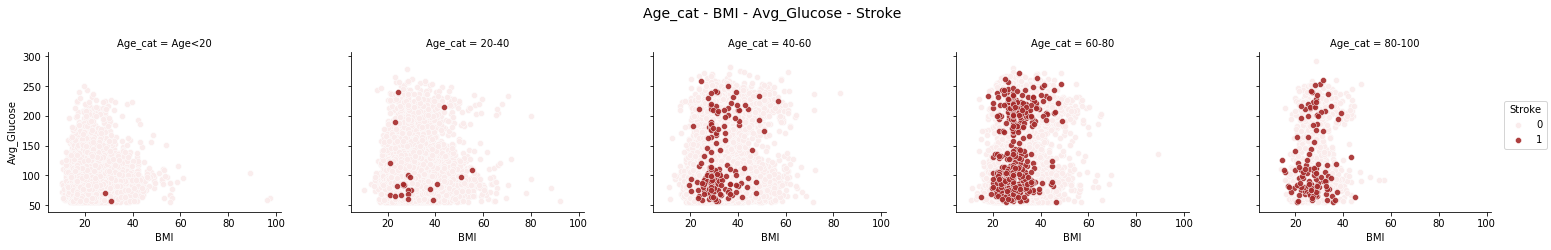

In [81]:
g = sns.FacetGrid(stroke_pred, col="Age_cat", hue='Stroke', 
                  col_order=['Age<20', '20-40', '40-60','60-80', '80-100'], hue_order=[0,1],
                  aspect=1.2, size=3.5, palette=sns.light_palette('brown', 2))
g.map(plt.scatter, "BMI", "Avg_Glucose", alpha=0.9, 
      edgecolor='white', linewidth=0.5)
    
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Age_cat - BMI - Avg_Glucose - Stroke', fontsize=14)
l = g.add_legend(title='Stroke')

In [78]:
compare(
    partial(nb_percent_stroke_equal, stroke_pred,'Age_cat','Age<20','Stroke'),'Age<20',
    partial(nb_percent_stroke_equal, stroke_pred,'Age_cat','20-40','Stroke'),'20-40',
    partial(nb_percent_stroke_equal, stroke_pred,'Age_cat','40-60','Stroke'),'40-60',
    partial(nb_percent_stroke_equal, stroke_pred,'Age_cat','60-80','Stroke'),'60-80',
    partial(nb_percent_stroke_equal, stroke_pred,'Age_cat','80-100','Stroke'),'80-100',
    )

,Age<20,20-40,40-60,60-80,80-100
Nb observations,8515.00,10666.00,13092.00,9690.00,1420.00
Stroke nb,2.00,22.00,167.00,464.00,128.00
Stroke %,0.02,0.21,1.28,4.79,9.01


In [76]:
stroke_pred.head(3)

,Gender,Age,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,BMI_range,BMI_cat,Avg_Glucose_range,Avg_Glucose_cat,Age_range,Age_cat
0,Male,3.024658,0,0,No,children,Rural,95.12,18.0,never smoked,0,"(0.0, 18.5]",Underweight,"(60, 140]",Normal AG,"(0, 20]",Age<20
1,Male,58.093151,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,"(29.9, 49.9]",Obese,"(60, 140]",Normal AG,"(40, 60]",40-60
2,Female,8.021918,0,0,No,Private,Urban,110.89,17.6,never smoked,0,"(0.0, 18.5]",Underweight,"(60, 140]",Normal AG,"(0, 20]",Age<20


**Save dataframe as a file**

In [38]:
file_to_save = 'stroke_predcopy.csv'
if not os.path.exists(file_to_save):
    stroke_pred.to_csv(file_to_save,sep = ",",index=False, chunksize=100)
        
else:
    file_to_save = 'stroke_pred.csv'
    stroke_pred.to_csv(file_to_save,sep = ",",index=False, chunksize=100)

**Misc.**

In [ ]:
Printf (to print results of removing N/As...)

https://stackoverflow.com/questions/19457227/how-to-print-like-printf-in-python3

In [ ]:
Multivariate 

Select numeric: correlation matrix
    
Select categorical: Djakare binary   (NOT DONE)